In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
size = np.int(1e4)
sns.set(style="darkgrid")

dict = {'N(0,1)':np.random.normal(0,1,size),'N(2,1)':np.random.normal(4,1,size),'N(0,5)':np.random.normal(0,5,size),
       'N(4,2)':np.random.normal(4,2,size),'N(2,3)':np.random.normal(2,3,size),'N(-1,5)':np.random.normal(-1,5,size)}
df = pd.DataFrame(dict)
df.head(5)

,"N(0,1)","N(2,1)","N(0,5)","N(4,2)","N(2,3)","N(-1,5)"
0,-0.857597,4.888641,5.630597,2.939536,-2.342116,4.358321
1,2.311619,3.623593,-6.286669,5.991184,2.611597,0.611946
2,0.292416,5.617393,3.851450,1.133768,5.867218,-1.505790
3,0.495920,4.020635,2.272419,3.827824,-2.484609,-0.728943
4,0.324719,5.416192,-2.393972,4.533496,1.560266,0.591792


In [36]:
def draw(data,bins):
    
    df_melted = pd.melt(data, value_vars = data.columns)
    
    g = sns.FacetGrid(data = df_melted,  col = "variable", col_wrap = 3, sharex = False)
    g = g.map(sns.distplot, "value", bins=bins, kde = False)

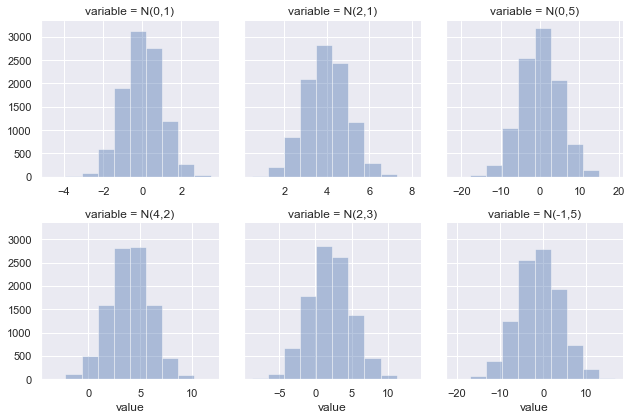

In [37]:
draw(data = df,bins = 10)

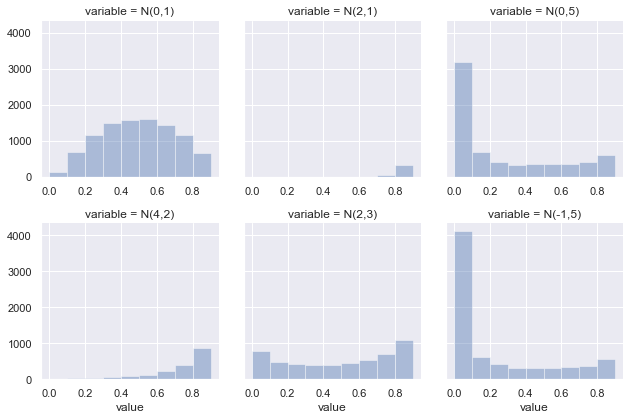

In [39]:
from scipy.special import expit

inv_df = expit(df.sample(size))
draw(inv_df,np.arange(0,1,0.1))

In [40]:
poisson_dict = {'poisson(1)': np.random.poisson( 1, size),'poisson(5)': np.random.poisson(5, size),'poisson(2)': np.random.poisson(2, size),
               'poisson(0)': np.random.poisson(0, size),'poisson(3.4)': np.random.poisson(3.4, size),'poisson(0.3)': np.random.poisson(0.3, size)}
poisson_df = pd.DataFrame(poisson_dict)
poisson_df.head(5)

,poisson(1),poisson(5),poisson(2),poisson(0),poisson(3.4),poisson(0.3)
0,0,2,5,0,6,0
1,3,6,0,0,5,0
2,0,7,0,0,2,1
3,0,6,1,0,7,0
4,1,1,2,0,1,0


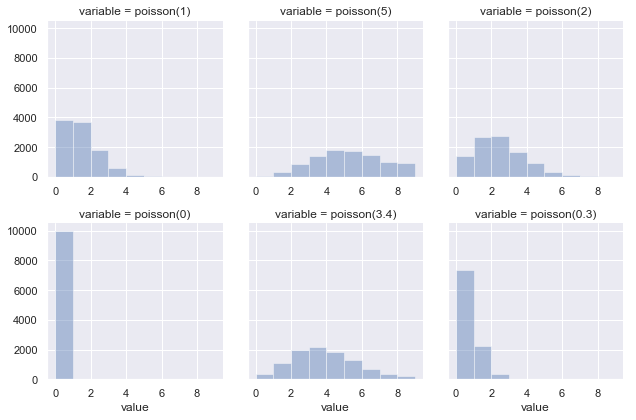

In [42]:
draw(poisson_df,bins = np.arange(0,10,1))

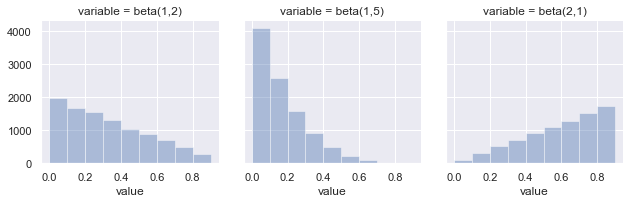

In [49]:
beta_dict = {'beta(1,2)': np.random.beta(1, 2, 10000),'beta(1,5)': np.random.beta(1,5, 10000),'beta(2,1)': np.random.beta(2, 1, 10000)}
beta_df = pd.DataFrame(beta_dict)
beta_df.head(5)
draw(beta_df,bins = np.arange(0,1,0.1))

In [56]:
def location(alpha, beta):
    return alpha / (alpha + beta)
def dispersion(alpha, beta):
    temp = location(alpha, beta)
    return temp * (1 - temp) * (1/(alpha + beta + 1))

def mean (alpha, beta):
    return alpha / (alpha + beta)
def population (alpha, beta):
    return (alpha + beta)

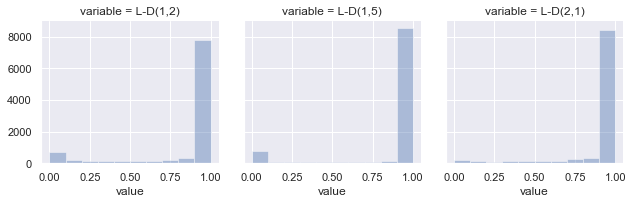

In [66]:
loc_dis = {
    'L-D(1,2)':np.random.beta(location(1,2), dispersion(1,2), size),
    'L-D(1,5)':np.random.beta(location(1,5), dispersion(1,5), size),
    'L-D(2,1)':np.random.beta(location(2,1), dispersion(2,1), size)}

loc_dis_df = pd.DataFrame(loc_dis)
draw(loc_dis_df, np.arange(0,1.1,0.1))

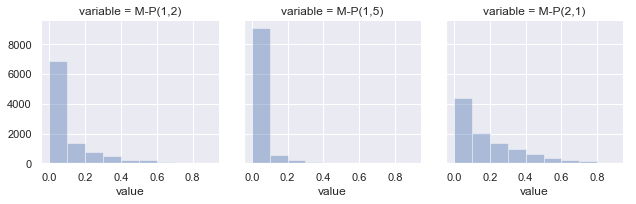

In [67]:
mean_pop = {
    'M-P(1,2)':np.random.beta(mean(1,2), population(1,2), size),
    'M-P(1,5)':np.random.beta(mean(1,5), population(1,5), size),
    'M-P(2,1)':np.random.beta(mean(2,1), population(2,1), size)}

mean_pop_df = pd.DataFrame(mean_pop)
draw(mean_pop_df, np.arange(0,1,0.1))

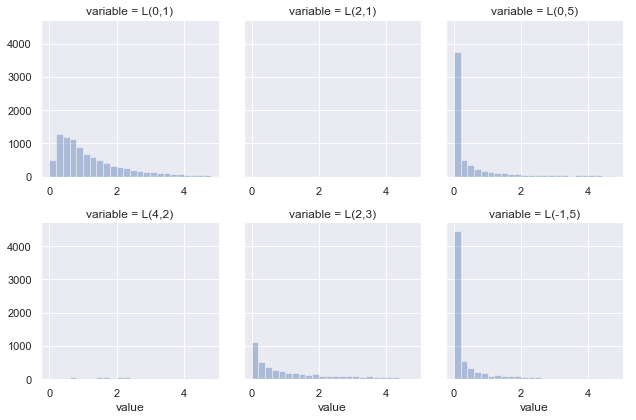

In [75]:
lognormal = {'L(0,1)':np.random.lognormal(0,1,size),'L(2,1)':np.random.lognormal(4,1,size),'L(0,5)':np.random.lognormal(0,5,size),
       'L(4,2)':np.random.lognormal(4,2,size),'L(2,3)':np.random.lognormal(2,3,size),'L(-1,5)':np.random.lognormal(-1,5,size)}

lognormal_df = pd.DataFrame(lognormal)
draw(lognormal_df, np.arange(0,5,0.2))